### EDA: Train Data

In [1]:
import pandas as pd
import numpy as np

# data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image

# model fit
import statsmodels.api as sm
import tensorflow as tf

# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')

2023-11-11 17:52:45.792786: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-11 17:52:45.855010: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-11 17:52:45.856372: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-11 17:52:46.763052: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train = pd.read_csv('train_data.csv')

In [3]:
train.head()

,area,region,sub-region,year,urban_population,mei,crop_residues,rice_cultivation,drained_organic_soils_co2,net_forest_conversion,...,20yr_drained_organic_soils_co2,20yr_net_forest_conversion,20yr_fires,20yr_manure_mgmt,20yr_food_systems,20yr_ippu_tot,20yr_on_farm_energy_use,20yr_forestland,20yr_total_emission,average_temperature_°c
0,Afghanistan,Asia,Southern Asia,1990,-0.222400,0.45222,-0.240110,-0.203939,-0.223168,-0.175706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.536167
1,Albania,Europe,Southern Europe,1990,-0.245859,0.45222,-0.282237,-0.241265,-0.215998,-0.175706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.735750
2,Algeria,Africa,Northern Africa,1990,-0.039527,0.45222,-0.252005,-0.242347,-0.223168,-0.169193,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.005583
3,American Samoa,Oceania,Polynesia,1990,-0.265271,0.45222,-0.299281,-0.190398,-0.223168,-0.175630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.566500
4,Andorra,Europe,Southern Europe,1990,-0.265044,0.45222,-0.166004,-0.190398,-0.223168,-0.175706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.278500


In [25]:
feat = ['average_temperature_°c', 'year', 'urban_population', 'mei', 'total_emission']
feat_5yr = ['average_temperature_°c', '5yr_crop_residues', '5yr_rice_cultivation','5yr_manure_mgmt', '5yr_food_systems', '5yr_ippu_tot', '5yr_total_emission']
feat_10yr = ['average_temperature_°c', '10yr_crop_residues', '10yr_rice_cultivation', '10yr_manure_mgmt', '10yr_food_systems', '10yr_ippu_tot', '10yr_total_emission']
feat_20yr = ['average_temperature_°c', '20yr_crop_residues', '20yr_rice_cultivation', '20yr_manure_mgmt', '20yr_food_systems', '20yr_ippu_tot', '20yr_total_emission']

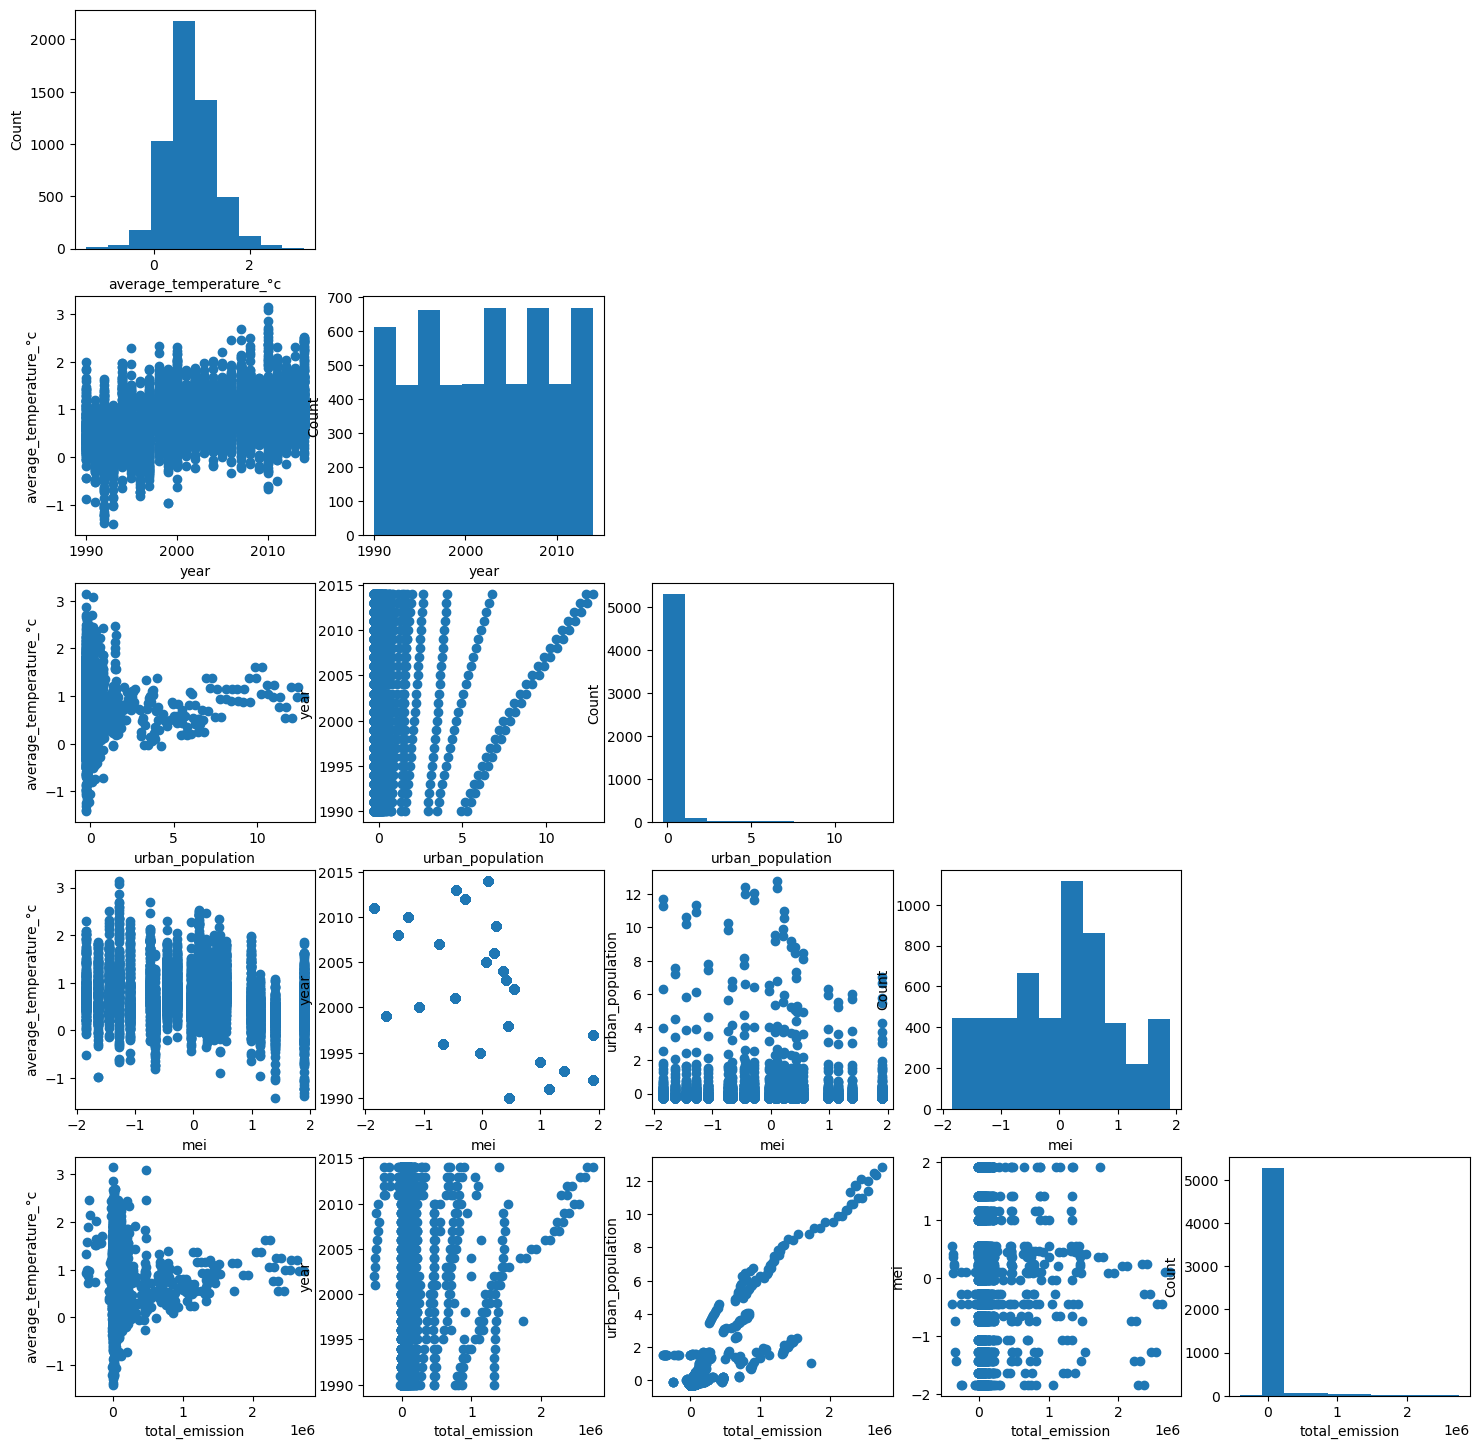

In [26]:
scatterplotmatrix(
    train[feat].values,
    names=feat,
    figsize=(18,18), alpha=1
);

In [35]:
#Print correlation matrix
cols = ['average_temperature_°c', 'area','region','sub-region','year','urban_population','mei','crop_residues','rice_cultivation',
        'drained_organic_soils_co2','net_forest_conversion','fires','manure_mgmt','food_systems','ippu_tot',
        'on_farm_energy_use','forestland','total_emission']
print(train[cols].corr())

                           average_temperature_°c      year  urban_population  \
average_temperature_°c                   1.000000  0.402037          0.030171   
year                                     0.402037  1.000000          0.044270   
urban_population                         0.030171  0.044270          1.000000   
mei                                     -0.223820 -0.545164         -0.023549   
crop_residues                            0.009352  0.027315          0.841549   
rice_cultivation                        -0.021804 -0.000033          0.854591   
drained_organic_soils_co2                0.020977  0.007297          0.188364   
net_forest_conversion                   -0.024762 -0.017960          0.153363   
fires                                   -0.038272 -0.002916          0.082187   
manure_mgmt                              0.011675  0.011347          0.870233   
food_systems                             0.041902  0.042335          0.961096   
ippu_tot                    